In [1]:
from typing import *
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
sns.set_context("notebook")

# Load results

In [2]:
df = pd.concat([
    pd.read_json("../../out/sweep_4bit.jsonl", lines=True),
]).reset_index()

# Derived
df["model"] = df["model"].apply(lambda s: s.split("/")[1])
df["compression"] = df["quantised_bytes"] / (2 * df["parameters"])
df["custom_embedding"] = df["unembedding_format_name"].apply(lambda s: isinstance(s, str))
df["name"] = df.apply(lambda s: s.format_name + ("+emb" if s.custom_embedding else ""), axis=1)
df = df.rename(columns={c: dict(outcompare="oc", arc_easy="arc", lambada_openai="lam")[c.split(":")[0]] + "_" + c.split(":")[1] for c in df.columns if ":" in c})

def get_element_dtype(d: Dict[str, Any]) -> str:
     if d["_type"] == "scalar":
          return f"E{d['exponent_bits']}M{d['mantissa_bits']}"
     if d["_type"] == "exp":
          return f"EXP{d['exponent_bits']}"
     assert d["_type"] == "linear", d["_type"]
     return get_element_dtype(d["element_format"])

def get_scale_dtype(d: Dict[str, Any]) -> str:
     if d["_type"] == "linear":
          return get_element_dtype(d["scale_format"])

def get_input_group_size(d: Dict[str, Any]) -> Optional[int]:
     if d["_type"] == "linear":
          shapes = d["group_shapes"]
          if len(shapes) == 1:
               if shapes[0][0] == 1:
                    return shapes[0][1]

df["element_dtype"] = df["format"].apply(get_element_dtype)
df["scale_dtype"] = df["format"].apply(get_scale_dtype)
df["group_size"] = df["format"].apply(get_input_group_size)

display(df.sort_values("compression")
        [["model", "compression", "name", "oc_entropy_rmse", "oc_exact_match_length", "oc_time"]].head(5))

print("Rows", len(df))

,model,compression,name,oc_entropy_rmse,oc_exact_match_length,oc_time
3,pythia-1.4b,0.250725,E0M3{1.*:E5M10},0.873893,1.766667,1682.437239
43,pythia-1.4b,0.250725,E2M1{1.*:E5M10},0.547274,3.256667,1435.813143
83,pythia-1.4b,0.250725,E3M0{1.*:E5M10},0.720842,2.103333,1395.822106
126,opt-1.3b,0.250743,E0M3{1.*:E5M10},2.297035,0.936667,1436.544155
166,opt-1.3b,0.250743,E2M1{1.*:E5M10},0.350913,4.800000,1427.330470


Rows 246


# Analysis

## Group size 2 sometimes caused NaN (perhaps absmax==0?)

In [48]:
df[df.oc_entropy_rmse.isna()][["model", "format_name"]]

,model,format_name
6,pythia-1.4b,E0M3{1.2:E5M2}
26,pythia-1.4b,E0M3{1.2:E5M2}
86,pythia-1.4b,E3M0{1.2:E5M2}
106,pythia-1.4b,E3M0{1.2:E5M2}
129,opt-1.3b,E0M3{1.2:E5M2}
149,opt-1.3b,E0M3{1.2:E5M2}
169,opt-1.3b,E2M1{1.2:E5M2}
189,opt-1.3b,E2M1{1.2:E5M2}
209,opt-1.3b,E3M0{1.2:E5M2}
229,opt-1.3b,E3M0{1.2:E5M2}


## Metrics are correlated

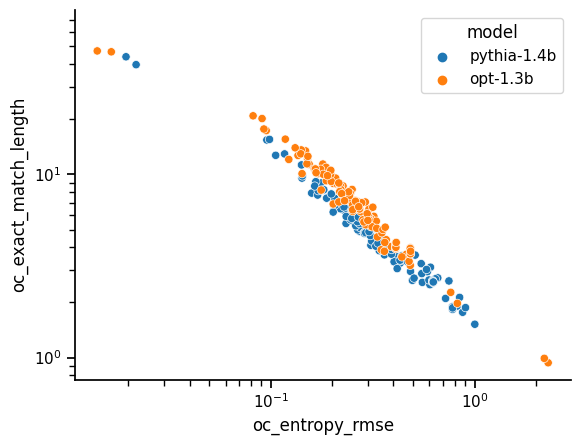

In [3]:
ax = sns.scatterplot(data=df, y="oc_exact_match_length", x="oc_entropy_rmse", hue="model")
ax.set_xscale("log"); ax.set_yscale("log"); sns.despine()

## Pareto frontier - `E2M1` looks good, with `E2M5` for the "unembedding" projection

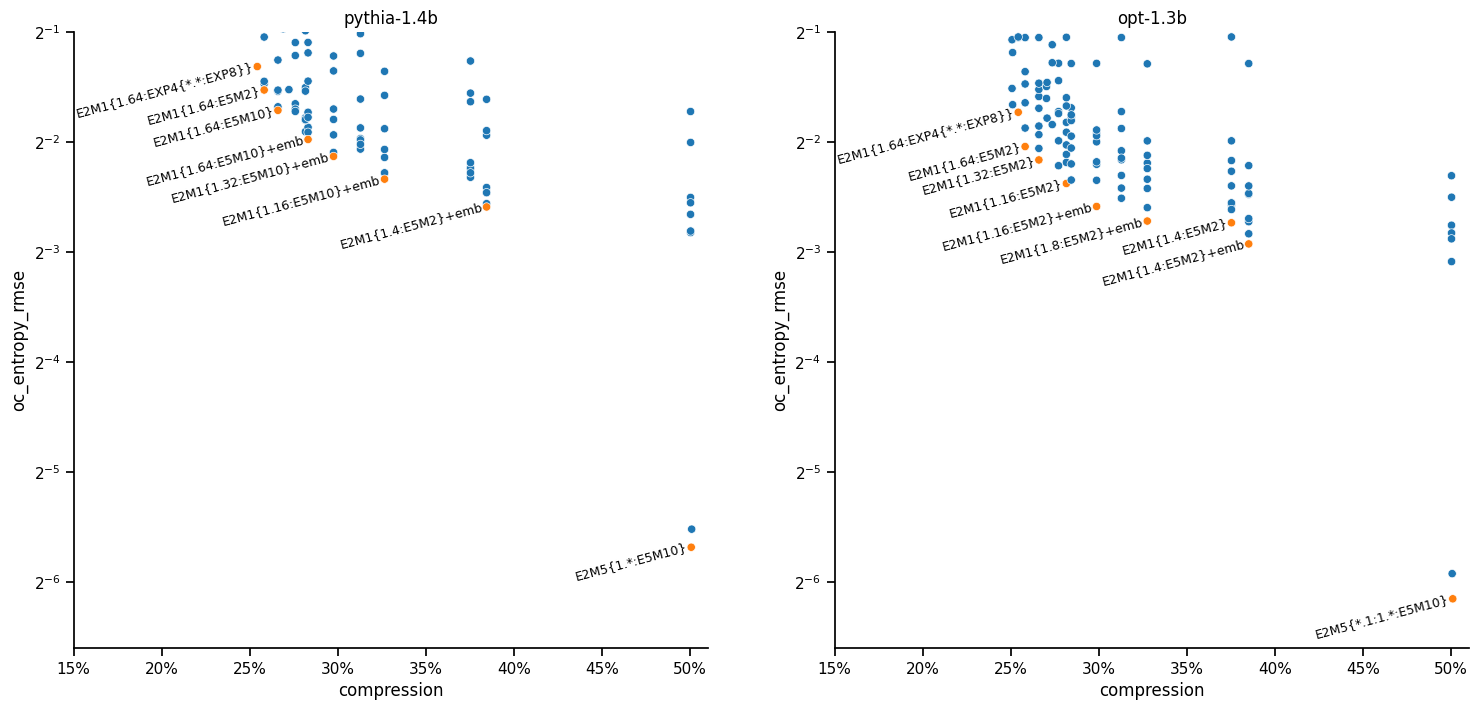

In [65]:
for (model, g), ax in zip(df.groupby("model", sort=False), plt.subplots(1, 2, figsize=(18, 8))[1]):
    d = g.assign(optimal=g.apply(lambda s: ~((np.round(100*g.compression) <= np.round(100*s.compression))
                                             & (g.oc_entropy_rmse < s.oc_entropy_rmse)).any(), axis=1))
    sns.scatterplot(data=d, y="oc_entropy_rmse", x="compression", hue="optimal", ax=ax)
    for _, s in d[d.optimal].iterrows():
        ax.annotate(s["name"], [s.compression, s.oc_entropy_rmse],
                    fontsize=9, ha="right", va="center", xytext=(-3, 0), textcoords="offset points",
                    rotation=15, rotation_mode="anchor")
    ax.set_xlim((0.15, 0.51))
    ax.set_ylim((2**-6.6, 2**-1))
    ax.legend_.remove()
    ax.set_yscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.set_title(model)
sns.despine()

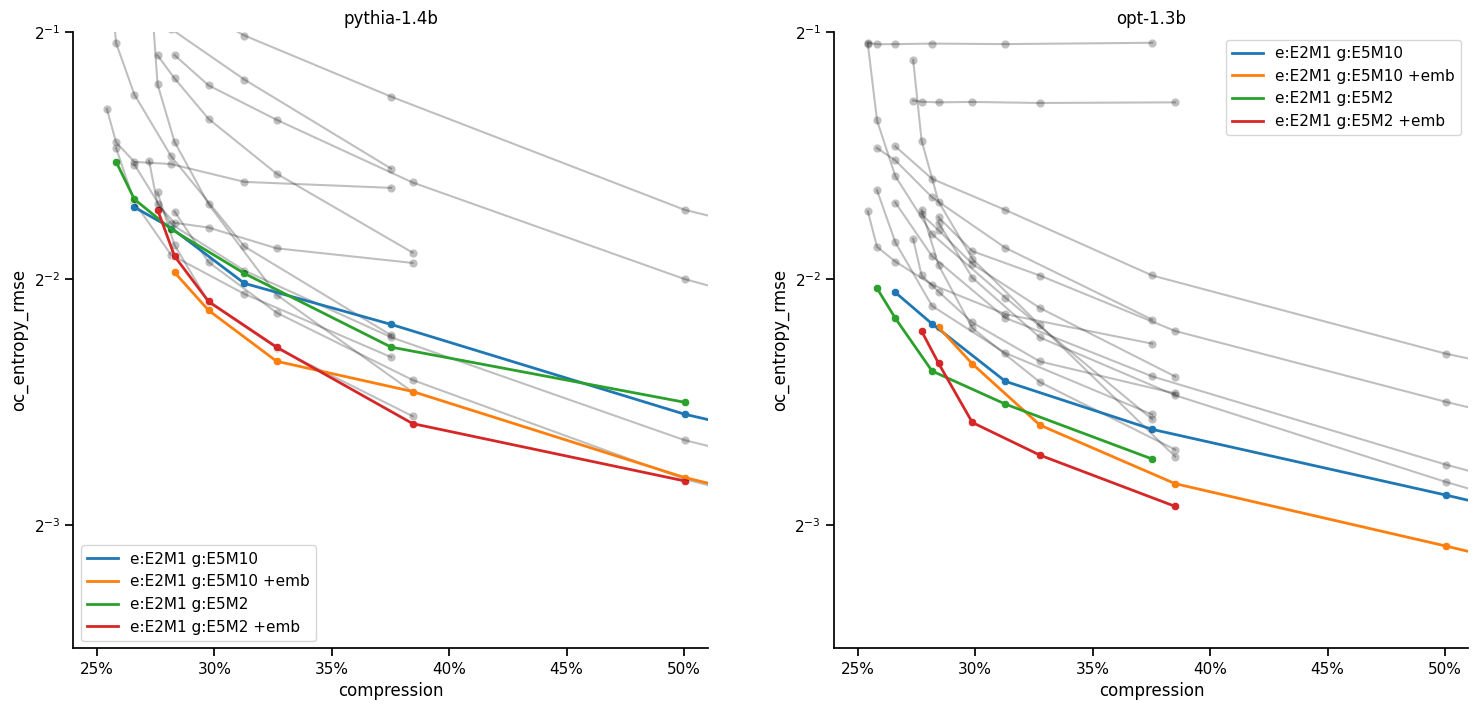

In [62]:
for (model, gg), ax in zip(df.groupby("model", sort=False), plt.subplots(1, 2, figsize=(18, 8))[1]):
    colors = iter(sns.color_palette())
    for id_, g in gg[~gg.group_size.isna()].groupby(["element_dtype", "scale_dtype", "custom_embedding"]):
        args = (dict(color=next(colors), label=f"e:{id_[0]} g:{id_[1]}" + (" +emb" if id_[2] else ""), lw=2)
                if id_[:2] in {("E2M1", "E5M10"), ("E2M1", "E5M2")} else
                dict(color="k", alpha=.25))
        for draw in [sns.lineplot, sns.scatterplot]:
            draw(data=g, y="oc_entropy_rmse", x="compression", ax=ax, **args)
            if "label" in args:
                del args["label"]
    ax.set_xlim((0.24, 0.51))
    ax.set_ylim((2**-3.5, 2**-1))
    ax.set_yscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.set_title(model)
sns.despine()

## Group schemes - `E2M1` is good, with `E5M2` or `E5M10` group scaling factors

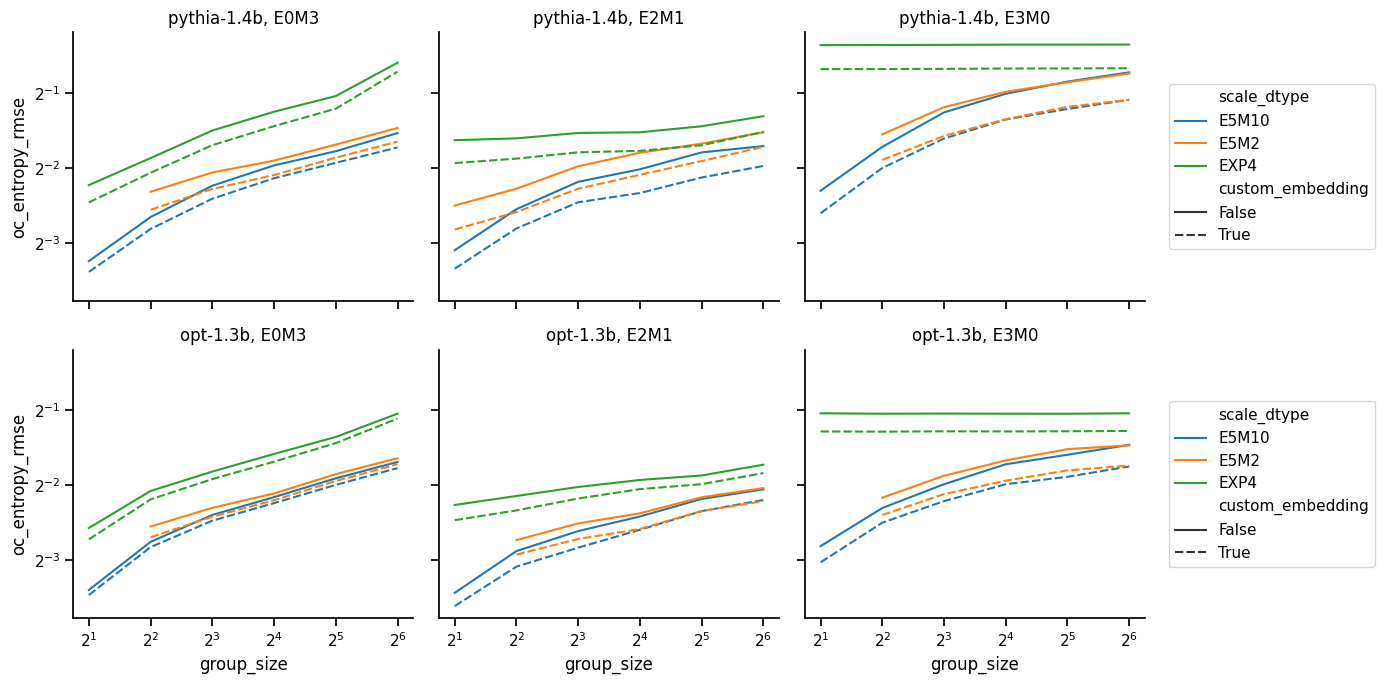

In [66]:
for (model, gg), axs in zip(df[~df.group_size.isna()].groupby("model", sort=False), plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True)[1]):
     for (dtype, g), ax in zip(gg.groupby("element_dtype", sort=False), axs):
        sns.lineplot(data=g, y="oc_entropy_rmse", x="group_size", hue="scale_dtype", style="custom_embedding", ax=ax)
        ax.set_xscale("log", base=2)
        ax.set_yscale("log", base=2)
        ax.legend_.remove()
        ax.set_title(f"{model}, {dtype}")
        if ax is axs[-1]:
            ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

plt.tight_layout() ; sns.despine()

## Example results for a decent scheme

In [76]:
display(df[df.name == "E2M1{1.16:E5M2}+emb"]
        [["name", "model", "compression", "oc_entropy_rmse", "oc_exact_match_length"]]
        .style.hide())

name,model,compression,oc_entropy_rmse,oc_exact_match_length
E2M1{1.16:E5M2}+emb,pythia-1.4b,0.297543,0.234440,5.896667
E2M1{1.16:E5M2}+emb,opt-1.3b,0.298757,0.166803,10.213333
